In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src import GaussianMixtureVolume

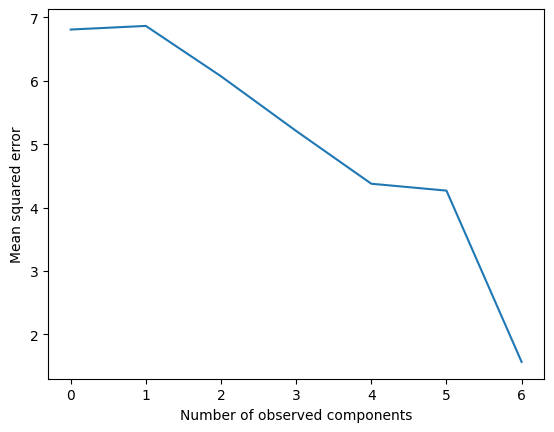

In [2]:
def randcov(m):
    A = np.random.randn(m, m)
    return np.dot(A, A.T)


dim = 7

weights = np.random.rand(3)
weights /= weights.sum()

mus = [np.random.randn(dim) for _ in range(len(weights))]
sigmas = [randcov(dim) for _ in range(len(weights))]


def sample(n):
    out = np.zeros((n, dim))
    for i in range(n):
        k = np.random.choice(len(weights), p=weights)
        out[i] = np.random.multivariate_normal(mus[k], sigmas[k])
    return out


X = sample(1000)

model = GaussianMixtureVolume(n_components=len(weights))
model.fit(sample(1000))

calc_mse = lambda pred, true: np.mean(np.square(true - pred))

MSE = [calc_mse(model.predict(), X)]
for i in range(dim - 1):
    MSE.append(calc_mse(model.predict(X[:, : i + 1]), X[:, i + 1 :]))

plt.plot(MSE)
plt.xlabel("Number of observed components")
plt.ylabel("Mean squared error")
plt.show()